## Section 1: Cancerous/non-cancerous detection

In [ ]:
seed = 630242

import pandas as pd
import numpy as np
np.random.seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score,classification_report

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Recall, Accuracy
from tensorflow.keras.regularizers import l2


2.12.0


In [ ]:
df_main = pd.read_csv('./data_labels_mainData.csv')
df_extra = pd.read_csv('./data_labels_extraData.csv')

In [ ]:
df_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## Approach
We will be analyzing the data from the main dataset, for our first image classification problem, predicting whether a cell is cancerous or not.

We will fit a Multi-Layer Perceptron with varying layers as our baseline model. Then we will make a full model using a Convolutional Neural Network.

## Data Analysis and Exploration
We will perform a exploratory data analysis of our dataset to figure out the best approach to the cancer cell classification problem.

We check how many patients are in the dataset as well as the distribution of how many image samples per patient.

In [ ]:
df_main['patientID'].nunique()

60

In [ ]:
df_main['patientID'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

There are 60 patients total in the dataset we're going to use.

We will need to split them into test-train-validation subsets based on this patientID feature for our cancer classification problem. This will be elaboated on later.


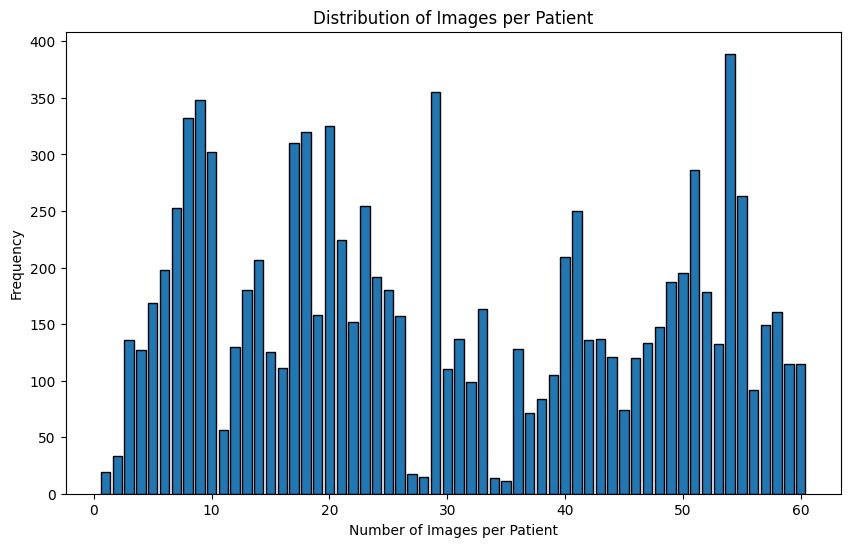

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df_main['patientID'].value_counts().index,df_main['patientID'].value_counts().values, edgecolor='black')
plt.xlabel('Number of Images per Patient')
plt.ylabel('Frequency')
plt.title('Distribution of Images per Patient')
plt.show()

We can see the number of image samples per patient is highly variable. So we must not split them solely based on number, but also by the number of instances per patient as well.

### Cancer cell distribution

In [ ]:
df_main['isCancerous'].value_counts()

0    5817
1    4079
Name: isCancerous, dtype: int64

We can see that there is not much imbalance of non-cancerous and cancerous cell images, which is will be beneficial for avoiding class imbalance and upholding the quality of our neural network training.

In [ ]:
# nested groupby checks whether there is a cancerous cell in a patient, then finds how many patients contain cancerous cells
df_main.groupby('patientID')['isCancerous'].max().reset_index().groupby('isCancerous').count()

,patientID
isCancerous,
0,26
1,34


The number of patients that have cancer is also evenly split, which will be beneficial for ensuring there is no class imbalance or leading to a low-quality generalisation.

### Cell type distribution

In [ ]:
df_main['cellType'].value_counts()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64

We can see an adequate distribution of class instances. This will ensure the balance of class types and allow for performant generalisations.

## Train-Test-Validation split

We will create a train-test-validation split of 60-20-20. This is chosen as we have enough samples in our dataset to train a highly accurate model, and we will have enough data left over for tuning and testing the accuracy of our model.

In [ ]:
train_ratio=0.6
val_ratio=0.2
test_ratio=0.2

# Stores list of patient IDs
patient_ids = df_main['patientID'].unique()
np.random.shuffle(patient_ids)

# Calculates number of samples for each split
num_samples = df_main.shape[0]
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

# Initializes the dataframes for the splits
df_train = pd.DataFrame()
df_val = pd.DataFrame()
df_test = pd.DataFrame()

# Iterates over patient IDs and assigns images to splits
for patient_id in patient_ids:
    patient_images = df_main[df_main['patientID'] == patient_id]
    
    # Adds Patient images to a split if it can fit in the allowed max.
    # train is allowed to be filled first, as it has to be fully filled 
    # as close to its 60% max as possible, taking advantage of patient
    # ID's with less images
    if df_train.shape[0] + patient_images.shape[0] <= num_train:
        df_train = pd.concat([df_train, patient_images])
    elif df_val.shape[0] + patient_images.shape[0] <= num_val:
        df_val = pd.concat([df_val, patient_images])
    else:
        df_test = pd.concat([df_test, patient_images])

print("Training samples:", df_train.shape[0])
print("Validation samples:", df_val.shape[0])
print("Testing samples:", df_test.shape[0])

Training samples: 5930
Validation samples: 1966
Testing samples: 2000


We will also create a manual test-train-validation split that takes into account the order of the data, which is grouped by patient ID's. We will compare the class distribution of both data splitting techniques for each data split.

In [ ]:
split_train,split_test = train_test_split(df_main,test_size = 0.2, shuffle=False,random_state=seed)
split_train,split_val = train_test_split(split_train,test_size = 0.25, shuffle=False,random_state=seed)

# Print the sizes of the resulting sets
print("Train set size:", split_train.shape[0])
print("Validation set size:", split_val.shape[0])
print("Test set size:", split_test.shape[0])

Train set size: 5937
Validation set size: 1979
Test set size: 1980


In [ ]:
df_train['isCancerous'].value_counts()

0    3315
1    2615
Name: isCancerous, dtype: int64

In [ ]:
split_train['isCancerous'].value_counts()

0    3544
1    2393
Name: isCancerous, dtype: int64

In [ ]:
df_val['isCancerous'].value_counts()

1    1169
0     797
Name: isCancerous, dtype: int64

In [ ]:
split_val['isCancerous'].value_counts()

0    1214
1     765
Name: isCancerous, dtype: int64

In [ ]:
df_test['isCancerous'].value_counts()

0    1705
1     295
Name: isCancerous, dtype: int64

In [ ]:
split_test['isCancerous'].value_counts()

0    1059
1     921
Name: isCancerous, dtype: int64

It appears as though our manual method of splitting the data into the different test-train-val subsets can keep a better balance of the classes (where classes 1 and 0 have less difference) than using train_test_split method for splitting the data, so we will proceed with this method, as it is better for preventing data leakage of patient IDs.

## Performance Metrics
The primary performance metrics we will use for our machine learning models are:

**Recall**: The ratio of correctly identified positives to all correct classifications. This is to deal with the fact that we have an imbalanced class distribution in the dataset, so we need to identify correctly classified instances out of the set that is fully true.

**F1-Score**: This is a metric that combines the metrics of accuracy and precision. 

**Area-Under-Curve (Area Under the Receiver Operating Characteristic Curve)**: This method plots the true positive rate against the false positive rate of the predictions across a varying "class probability" thresholds. This will be a useful metric for our baseline model, as we are not handling class imbalance in that prediction model.

## Fitting Baseline Model

We will now fit the data to our baseline model. We choose this to be a simple Multi-Layer Perceptron with 2 layers. This should be adequate enough to make a competant model while allowing for a fast and basic model fit to understand our potential performance.

Here we define the dimensions of our neural network.

In [ ]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM_1 = 256
HIDDEN_LAYER_DIM_2 = 256
OUTPUT_CLASSES = 1

We rely on a sequential API to build our baseline neural network.

In [ ]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_1, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_2, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 626,177
Trainable params: 626,177
Non-trainable params: 0
_________________________________________________________________


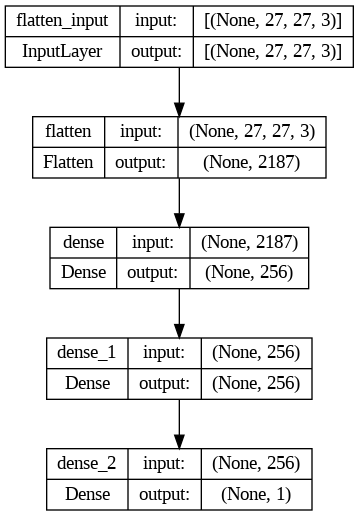

In [ ]:
tf.keras.utils.plot_model(baseline_model, show_shapes=True)

In [ ]:
from sklearn.metrics import f1_score

baseline_model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['AUC','Recall','accuracy'])

In our data generation, we set shuffle as false for the image data, this is so the batches can retain as much information as it can from a single patient ID, rather than having all of their data mixed up.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32
train_copy_1 = df_train.copy() # split_train.copy()
train_copy_1['isCancerous'] = train_copy_1['isCancerous'].astype(str)
val_copy_1 = df_val.copy() # split_val.copy()
val_copy_1['isCancerous'] = val_copy_1['isCancerous'].astype(str)
test_copy_1 = df_test.copy() #split_test.copy()
test_copy_1['isCancerous'] = test_copy_1['isCancerous'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_copy_1,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_copy_1,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,shuffle = False,
        class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_copy_1,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,shuffle = False,
        class_mode='binary')

Found 5930 validated image filenames belonging to 2 classes.
Found 1966 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
baseline_history = baseline_model.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=1)

Epoch 1/20
  1/186 [..............................] - ETA: 8s - loss: 0.0865 - auc: 1.0000 - recall: 1.0000 - accuracy: 1.0000

<ipython-input-117-29456fd23023>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  baseline_history = baseline_model.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=1)


186/186 [==============================] - 6s 32ms/step - loss: 0.3200 - auc: 0.8885 - recall: 0.8164 - accuracy: 0.8666 - val_loss: 0.3383 - val_auc: 0.8909 - val_recall: 0.7767 - val_accuracy: 0.8444
Epoch 2/20
186/186 [==============================] - 4s 20ms/step - loss: 0.3156 - auc: 0.8909 - recall: 0.8057 - accuracy: 0.8636 - val_loss: 0.3630 - val_auc: 0.8760 - val_recall: 0.7314 - val_accuracy: 0.8250
Epoch 3/20
186/186 [==============================] - 4s 23ms/step - loss: 0.3159 - auc: 0.8904 - recall: 0.8103 - accuracy: 0.8656 - val_loss: 0.3480 - val_auc: 0.8821 - val_recall: 0.7562 - val_accuracy: 0.8342
Epoch 4/20
186/186 [==============================] - 4s 20ms/step - loss: 0.3130 - auc: 0.8899 - recall: 0.8138 - accuracy: 0.8688 - val_loss: 0.3398 - val_auc: 0.8889 - val_recall: 0.7733 - val_accuracy: 0.8408
Epoch 5/20
186/186 [==============================] - 4s 20ms/step - loss: 0.3104 - auc: 0.8914 - recall: 0.8161 - accuracy: 0.8702 - val_loss: 0.5510 - val_au

In [ ]:
# Generates predictions for the test data
test_predictions = baseline_model.predict_generator(test_generator)

# Converts the probabilities to binary 
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Stores actual test data labels
test_labels = test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions_binary)
accuracy = (test_predictions_binary == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)

<ipython-input-120-7d3fcf0c1b35>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = baseline_model.predict_generator(test_generator)


Confusion Matrix:
[[1662   43]
 [  87  208]]
AUC Score: 0.9749748993488742
Recall: 0.7050847457627119
Accuracy: 0.7640225
63/63 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1705
           1       0.83      0.71      0.76       295

    accuracy                           0.94      2000
   macro avg       0.89      0.84      0.86      2000
weighted avg       0.93      0.94      0.93      2000



Here we write a helper function to help us display the classification report for all models.

In [ ]:
# prints the classification report given a model
def classification_rep(model):
  test_pred = model.predict(test_generator)
  # Converts prediction probabilities to binary values
  test_pred = (test_pred > 0.5).astype(int)
  print(classification_report(test_generator.labels, test_pred))
classification_rep(baseline_model)

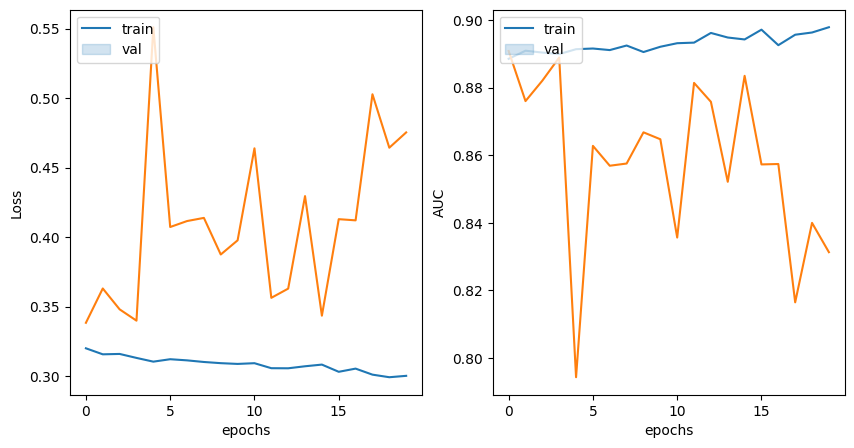

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=baseline_history.history, x=range(len(baseline_history.history['loss'])), y='loss', ax=axes[0])
sns.lineplot(data=baseline_history.history, x=range(len(baseline_history.history['val_loss'])), y='val_loss', ax=axes[0])

sns.lineplot(data=baseline_history.history, x=range(len(baseline_history.history['auc'])), y='auc', ax=axes[1])
sns.lineplot(data=baseline_history.history, x=range(len(baseline_history.history['val_auc'])), y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['train', 'val'], loc='upper left')
axes[1].legend(['train', 'val'], loc='upper left')

plt.show()

### Observations
We can see that the model is overfitting, as the validation data performance is unable to consistently perform with the training data performance, and is spiking everywhere. The training data is also consistently low which suggests the training data is being memorized by the MLP. This is reflected as well in the suspiciously high accuracy score (94%).

We will attempt to reduce the number of layers in our model to test if it can reduce overfitting.

In [ ]:
baseline_model_L1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_1, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
baseline_model_L1.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy'])

In [ ]:
baseline_history_L1 = baseline_model_L1.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=0)

<ipython-input-126-651f976b305f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  baseline_history_L1 = baseline_model_L1.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=0)


<ipython-input-127-cf8caf264152>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = baseline_model_L1.predict_generator(test_generator)


Confusion Matrix:
[[1591  114]
 [  25  270]]
AUC Score: 0.9692410159550674
Recall: 0.9152542372881356
Accuracy: 0.71714
63/63 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      1705
           1       0.70      0.92      0.80       295

    accuracy                           0.93      2000
   macro avg       0.84      0.92      0.88      2000
weighted avg       0.94      0.93      0.93      2000



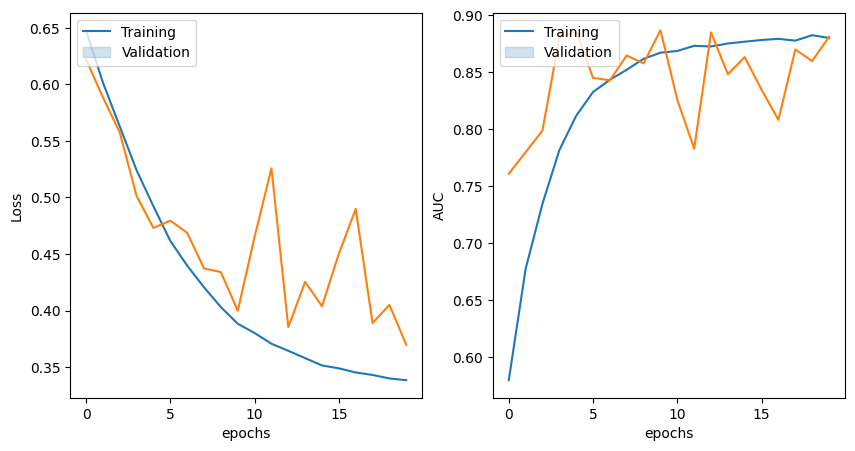

In [ ]:
# Generates predictions for the test data
test_predictions = baseline_model_L1.predict_generator(test_generator)

# Converts the probabilities to binary 
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Stores actual test data labels
test_labels = test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions_binary)
accuracy = (test_predictions_binary == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(baseline_model_L1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=baseline_history_L1.history, x=baseline_history_L1.epoch, y='loss', ax=axes[0])
sns.lineplot(data=baseline_history_L1.history, x=baseline_history_L1.epoch, y='val_loss', ax=axes[0])

sns.lineplot(data=baseline_history_L1.history, x=baseline_history_L1.epoch, y='auc', ax=axes[1])
sns.lineplot(data=baseline_history_L1.history, x=baseline_history_L1.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

The overfitting has been significantly improved. This means a 2 layer multi-layer perceptron is too complex for this dataset using a batch-size of 32.

We will attempt to further remedy the over-fitting by performing regularisation in the loss function for the MLP.

In [57]:
reg_lambda = 0.01

baseline_model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
baseline_model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy'])

In [ ]:
baseline_history_reg = baseline_model_reg.fit(train_generator, validation_data = validation_generator, epochs=20, verbose=0)

<ipython-input-131-51785c73ec4b>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = baseline_model_reg.predict_generator(test_generator)


Confusion Matrix:
[[1650   55]
 [  79  216]]
AUC Score: 0.9669824543963418
Recall: 0.7322033898305085
Accuracy: 0.7569725
63/63 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1705
           1       0.80      0.73      0.76       295

    accuracy                           0.93      2000
   macro avg       0.88      0.85      0.86      2000
weighted avg       0.93      0.93      0.93      2000



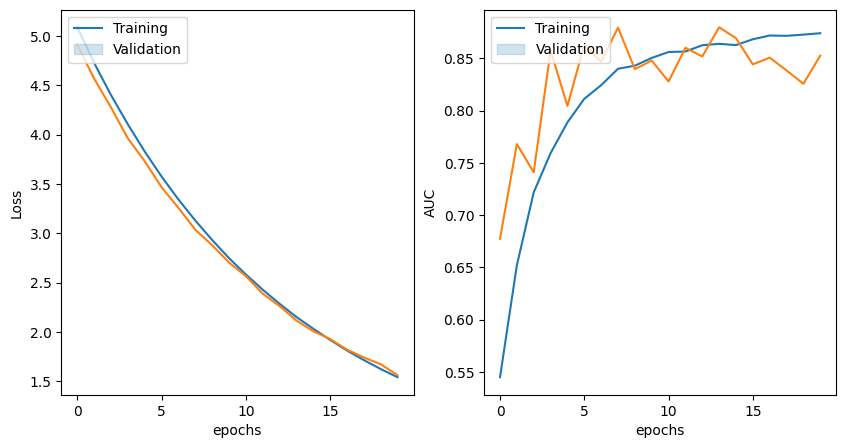

In [ ]:
# Generates predictions for the test data
test_predictions = baseline_model_reg.predict_generator(test_generator)

# Converts the probabilities to binary 
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Stores actual test data labels
test_labels = test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions_binary)
accuracy = (test_predictions_binary == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(baseline_model_reg)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=baseline_history_reg.history, x=baseline_history_reg.epoch, y='loss', ax=axes[0])
sns.lineplot(data=baseline_history_reg.history, x=baseline_history_reg.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=baseline_history_reg.history, x=baseline_history_reg.epoch, y='auc', ax=axes[1])
sns.lineplot(data=baseline_history_reg.history, x=baseline_history_reg.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

Overfitting issues have been greatly resolved.

We now try to reduce the number of neurons in our layer to see if it can better deal with overfitting.

<ipython-input-132-7c42220a3d1d>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  baseline_history_low = baseline_model_low.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=0)
<ipython-input-132-7c42220a3d1d>:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = baseline_model_low.predict_generator(test_generator)


Confusion Matrix:
[[1658   47]
 [  91  204]]
AUC Score: 0.9667518266315424
Recall: 0.6915254237288135
Accuracy: 0.7640225
63/63 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1705
           1       0.81      0.69      0.75       295

    accuracy                           0.93      2000
   macro avg       0.88      0.83      0.85      2000
weighted avg       0.93      0.93      0.93      2000



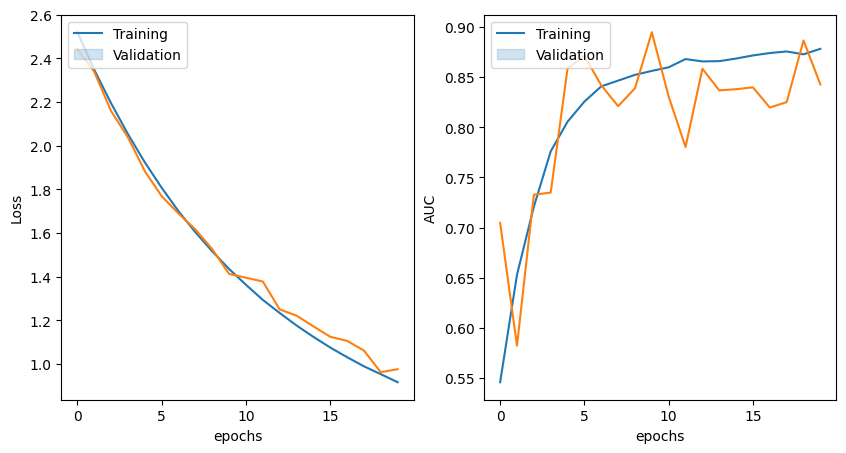

In [ ]:
reg_lambda = 0.01
HIDDEN_LAYER_DIM_3 = 100
baseline_model_low = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_3, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
baseline_model_low.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy'])
baseline_history_low = baseline_model_low.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=0)
# Generates predictions for the test data
test_predictions = baseline_model_low.predict_generator(test_generator)

# Converts the probabilities to binary 
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Stores actual test data labels
test_labels = test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions_binary)
accuracy = (test_predictions_binary == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(baseline_model_low)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=baseline_history_low.history, x=baseline_history_low.epoch, y='loss', ax=axes[0])
sns.lineplot(data=baseline_history_low.history, x=baseline_history_low.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=baseline_history_low.history, x=baseline_history_low.epoch, y='auc', ax=axes[1])
sns.lineplot(data=baseline_history_low.history, x=baseline_history_low.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

It appears this did not work, the performance is also worse and the AUC score is generally lower than before. So we will stick to using 256 neurons.
### Adding dropout
We will now add dropout to the baseline model to further combat the overfitting of the model. We start with a high dropout rate to get an idea of how much the model can be overfitting.

<ipython-input-139-43fd8844e2ef>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  baseline_history_drop = baseline_model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=0)
<ipython-input-139-43fd8844e2ef>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = baseline_model_drop.predict_generator(test_generator)


Confusion Matrix:
[[1673   32]
 [ 147  148]]
AUC Score: 0.9578269297678812
Recall: 0.5016949152542373
Accuracy: 0.78905
63/63 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1705
           1       0.82      0.50      0.62       295

    accuracy                           0.91      2000
   macro avg       0.87      0.74      0.79      2000
weighted avg       0.90      0.91      0.90      2000



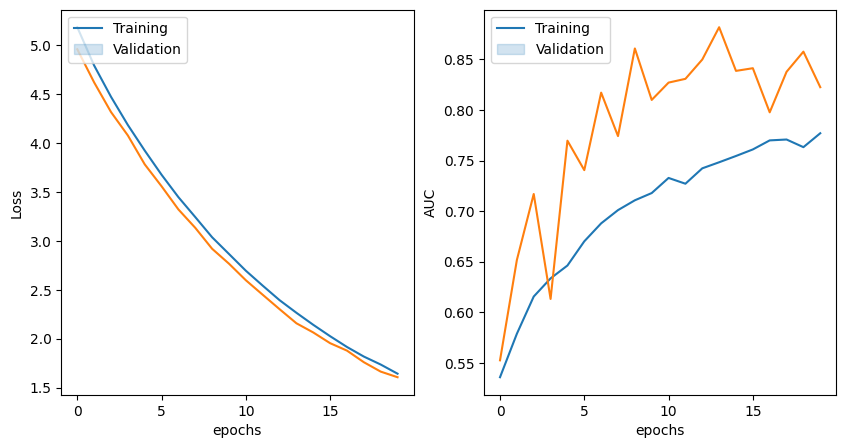

In [ ]:
reg_lambda = 0.01
dropout_rate = 0.7
baseline_model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
baseline_model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy'])
baseline_history_drop = baseline_model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=0)

# Generates predictions for the test data
test_predictions = baseline_model_drop.predict_generator(test_generator)

# Converts the probabilities to binary 
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Stores actual test data labels
test_labels = test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions_binary)
accuracy = (test_predictions_binary == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(baseline_model_drop)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=baseline_history_drop.history, x=baseline_history_drop.epoch, y='loss', ax=axes[0])
sns.lineplot(data=baseline_history_drop.history, x=baseline_history_drop.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=baseline_history_drop.history, x=baseline_history_drop.epoch, y='auc', ax=axes[1])
sns.lineplot(data=baseline_history_drop.history, x=baseline_history_drop.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

The overfitting with a 0.7 dropout rate is extreme, so we will make a lower dropout rate.

<ipython-input-142-120ccb84e7e5>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  baseline_history_drop = baseline_model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=0)
<ipython-input-142-120ccb84e7e5>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = baseline_model_drop.predict_generator(test_generator)


Confusion Matrix:
[[1655   50]
 [  86  209]]
AUC Score: 0.966787613698494
Recall: 0.7084745762711865
Accuracy: 0.7612025
63/63 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1705
           1       0.81      0.71      0.75       295

    accuracy                           0.93      2000
   macro avg       0.88      0.84      0.86      2000
weighted avg       0.93      0.93      0.93      2000



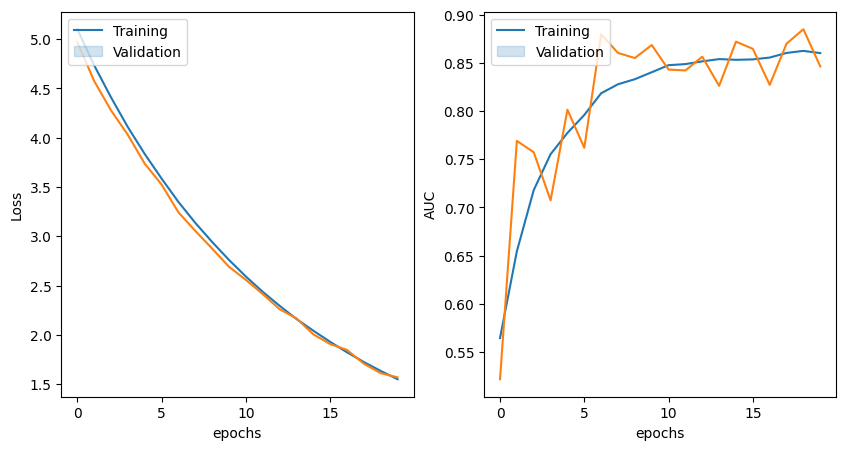

In [ ]:
reg_lambda = 0.01
dropout_rate = 0.1
baseline_model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
baseline_model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy'])
baseline_history_drop = baseline_model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=0)

# Generates predictions for the test data
test_predictions = baseline_model_drop.predict_generator(test_generator)

# Converts the probabilities to binary 
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Stores actual test data labels
test_labels = test_generator.labels
cm = confusion_matrix(test_labels, test_predictions_binary)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions_binary)
accuracy = (test_predictions_binary == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(baseline_model_drop)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=baseline_history_drop.history, x=baseline_history_drop.epoch, y='loss', ax=axes[0])
sns.lineplot(data=baseline_history_drop.history, x=baseline_history_drop.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=baseline_history_drop.history, x=baseline_history_drop.epoch, y='auc', ax=axes[1])
sns.lineplot(data=baseline_history_drop.history, x=baseline_history_drop.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

The dropout technique shows a decent improvement in reducing the overfitting.

### Dealing with class imbalance
Our dataset contains 5817 non-cancerous and 4079 cancerous cell images. We will deal with this large class imbalance using class_weights. 

This is due to the fact that a class-balancing technique like undersampling can lead to lower performance, as less data is used in training. So class_weights lets us retain our original dataset volume.

In [ ]:
# Store sample sizes
num_non_cancerous = train_copy_1[train_copy_1['isCancerous'] == '0'].shape[0]
num_cancerous = train_copy_1[train_copy_1['isCancerous'] == '1'].shape[0]
# Calculates the class weights
total_samples = train_copy_1.shape[0]
class_weight = {0: total_samples / (2 * num_non_cancerous), 1: total_samples / (2 * num_cancerous)}

<ipython-input-144-c0bdc4dffd47>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  baseline_history_weight = baseline_model_weight.fit_generator(train_generator, validation_data=validation_generator, epochs=20, verbose=0, class_weight=class_weight)
<ipython-input-144-c0bdc4dffd47>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = baseline_model_weight.predict_generator(test_generator)


Confusion Matrix:
[[1628   77]
 [  42  253]]
AUC Score: 0.9667955663800388
Recall: 0.8576271186440678
Accuracy: 0.736175
63/63 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1705
           1       0.77      0.86      0.81       295

    accuracy                           0.94      2000
   macro avg       0.87      0.91      0.89      2000
weighted avg       0.94      0.94      0.94      2000



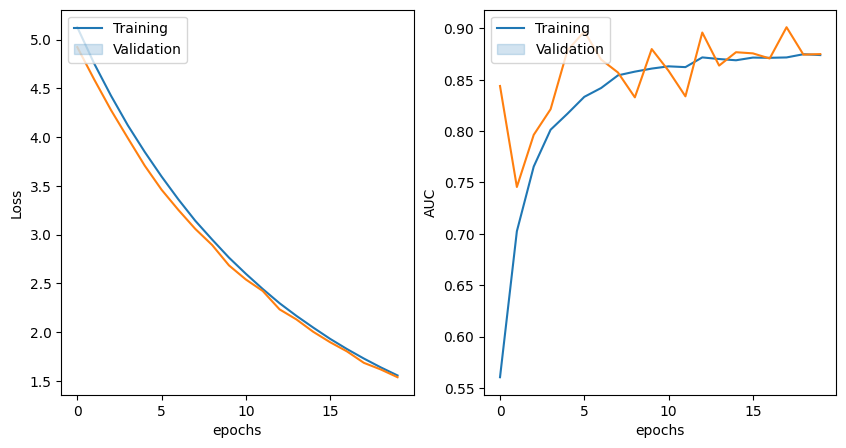

In [ ]:
reg_lambda = 0.01
dropout_rate = 0.1
baseline_model_weight = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
baseline_model_weight.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy'])
baseline_history_weight = baseline_model_weight.fit_generator(train_generator, validation_data=validation_generator, epochs=20, verbose=0, class_weight=class_weight)

# Generates predictions for the test data
test_predictions = baseline_model_weight.predict_generator(test_generator)

# Converts the probabilities to binary 
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Stores actual test data labels
test_labels = test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions_binary)
accuracy = (test_predictions_binary == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(baseline_model_weight)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=baseline_history_weight.history, x=baseline_history_weight.epoch, y='loss', ax=axes[0])
sns.lineplot(data=baseline_history_weight.history, x=baseline_history_weight.epoch, y='val_loss', ax=axes[0])

sns.lineplot(data=baseline_history_weight.history, x=baseline_history_weight.epoch, y='auc', ax=axes[1])
sns.lineplot(data=baseline_history_weight.history, x=baseline_history_weight.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

Using class_weights to balance the model seems to be worsening the model overall, so we will avoid using this to increase the score on our testing data.

## Section 2: Creating full cancer cell detection classifier

We have enough of an idea of what we need to do to build a performant cancer cell Machine Learning Deep Learning classifier. We will use certain parameters from our best performing baseline models to create a full deep-learning CNN model for predicting images.

In [ ]:
# Define hyperparameters
dropout_rate = 0.1
FILTERS = 32  # Number of filters in the convolutional layers
KERNEL_SIZE = (3, 3)  # Kernel size for convolutional layers
POOL_SIZE = (2, 2)  # Pooling size for max pooling layers
DENSE_UNITS = 128  # Number of units in the dense layers

# Create the model
CNN_model = Sequential([
    Conv2D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu', input_shape=INPUT_DIM),
    MaxPooling2D(pool_size=POOL_SIZE),
    Conv2D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    MaxPooling2D(pool_size=POOL_SIZE),
    Flatten(),
    Dense(units=DENSE_UNITS, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(rate=dropout_rate),
    Dense(units=1, activation='sigmoid')
])
# Compile the model
CNN_model.compile(optimizer=Adam(),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy', 'AUC', 'Recall', 'binary_accuracy'])
# Print model summary
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

Epoch 1/40
186/186 [==============================] - 4s 23ms/step - loss: 0.2662 - accuracy: 0.9040 - auc: 0.9642 - recall: 0.8910 - binary_accuracy: 0.9040 - val_loss: 0.5256 - val_accuracy: 0.7864 - val_auc: 0.9425 - val_recall: 0.6664 - val_binary_accuracy: 0.7864
Epoch 2/40
186/186 [==============================] - 4s 21ms/step - loss: 0.2735 - accuracy: 0.8980 - auc: 0.9620 - recall: 0.8826 - binary_accuracy: 0.8980 - val_loss: 0.4768 - val_accuracy: 0.8108 - val_auc: 0.9496 - val_recall: 0.7092 - val_binary_accuracy: 0.8108
Epoch 3/40
186/186 [==============================] - 5s 28ms/step - loss: 0.2687 - accuracy: 0.9003 - auc: 0.9638 - recall: 0.8891 - binary_accuracy: 0.9003 - val_loss: 0.4579 - val_accuracy: 0.8189 - val_auc: 0.9374 - val_recall: 0.7237 - val_binary_accuracy: 0.8189
Epoch 4/40
186/186 [==============================] - 4s 22ms/step - loss: 0.2776 - accuracy: 0.8938 - auc: 0.9608 - recall: 0.8730 - binary_accuracy: 0.8938 - val_loss: 0.3351 - val_accuracy: 

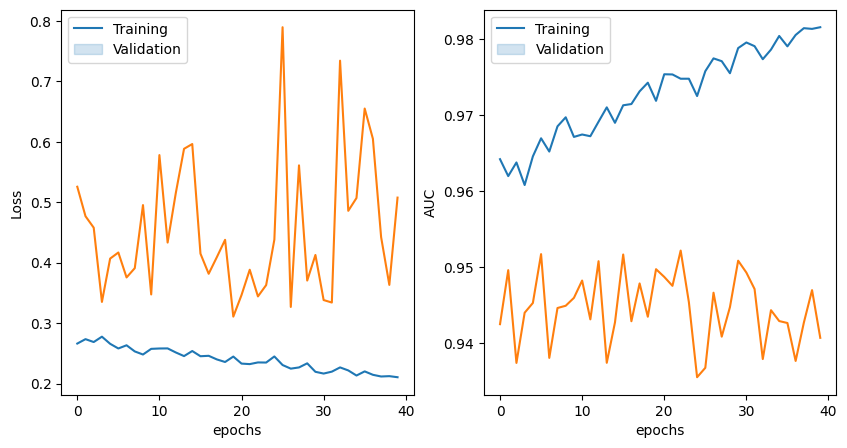

In [ ]:
history = CNN_model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=40,
                        verbose=1)

# Evaluate the model on the test data
test_loss,test_accuracy, test_auc, test_recall,binary_accuracy  = CNN_model.evaluate(test_generator)

# Print the test metrics
print("Test Loss:", test_loss)
print("Test AUC:", test_auc)
print("Test Recall:", test_recall)
print("Test binary_accuracy:", binary_accuracy)
classification_rep(CNN_model)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=history.history, x=history.epoch, y='loss', ax=axes[0])
sns.lineplot(data=history.history, x=history.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=history.history, x=history.epoch, y='auc', ax=axes[1])
sns.lineplot(data=history.history, x=history.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

## Testing cancer classification model performance on the Extra dataset

In [ ]:
# Uses same code as earlier to generate testing data from the extra dataset
extra_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32
extra_test_copy = df_extra.copy() # split_train.copy()
extra_test_copy['isCancerous'] = extra_test_copy['isCancerous'].astype(str)

extra_test_generator = extra_test_datagen.flow_from_dataframe(
        dataframe=extra_test_copy,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')
# Evaluate the model on the test data
test_loss,test_accuracy, test_auc, test_recall,binary_accuracy  = CNN_model.evaluate(extra_test_generator)

# Print the test metrics
print("Test Loss:", test_loss)
print("Test AUC:", test_auc)
print("Test Recall:", test_recall)
print("Test binary_accuracy:", binary_accuracy)
test_pred = CNN_model.predict(extra_test_generator)
test_pred = (test_pred > 0.5).astype(int)
print(classification_report(extra_test_generator.labels, test_pred))

Found 10384 validated image filenames belonging to 2 classes.
325/325 [==============================] - 7s 21ms/step - loss: 0.7282 - accuracy: 0.7276 - auc: 0.9279 - recall: 0.9612 - binary_accuracy: 0.7276
Test Loss: 0.728193998336792
Test AUC: 0.9279327988624573
Test Recall: 0.9612039923667908
Test binary_accuracy: 0.7275616526603699
325/325 [==============================] - 4s 14ms/step
              precision    recall  f1-score   support

           0       0.72      0.47      0.57      7394
           1       0.29      0.55      0.38      2990

    accuracy                           0.49     10384
   macro avg       0.51      0.51      0.47     10384
weighted avg       0.60      0.49      0.51     10384



We've found that our model has been overfitting to the data, which explains the extremely high testing prediction scores.

## Cell type classification

In [ ]:
cell_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32
cell_train = df_train.copy() # split_train.copy()
cell_train['cellType'] = cell_train['cellType'].astype(str)
cell_val = df_val.copy() # split_val.copy()
cell_val['cellType'] = cell_val['cellType'].astype(str)
cell_test = df_test.copy() #split_test.copy()
cell_test['cellType'] = cell_test['cellType'].astype(str)

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=cell_train,
        directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator = cell_val_datagen.flow_from_dataframe(
        dataframe=cell_val,
        directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,shuffle = False,
        class_mode='categorical')

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=cell_test,
        directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,shuffle = False,
        class_mode='categorical')

Found 5930 validated image filenames belonging to 4 classes.
Found 1966 validated image filenames belonging to 4 classes.
Found 2000 validated image filenames belonging to 4 classes.


In [ ]:
# prints the classification report given a model
def classification_rep(model):
  test_pred = model.predict(cell_test_generator)
  # Converts prediction probabilities to binary values
  test_pred = np.argmax(test_pred, axis=1)
  print(classification_report(cell_test_generator.labels, test_pred, zero_division=0))

We start off with a basic MLP for our first baseline classification model for cell type. We will use 2 layers to see if the complexity can aid our new classification class size.

In [63]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM_1 = 256
HIDDEN_LAYER_DIM_2 = 256
OUTPUT_CLASSES = 4

In [ ]:
cell_baseline_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_1),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_2, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])
cell_baseline_model.summary()
cell_baseline_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy','categorical_accuracy'])
cell_baseline_history = cell_baseline_model.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=20, verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2187)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               560128    
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dense_20 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 626,948
Trainable params: 626,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


<ipython-input-53-1ca2b64eed9f>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cell_baseline_history = cell_baseline_model.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=20, verbose=1)
/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


186/186 [==============================] - 5s 21ms/step - loss: 1.2300 - auc: 0.7204 - recall: 0.2668 - accuracy: 0.4887 - categorical_accuracy: 0.4887 - val_loss: 1.2294 - val_auc: 0.7199 - val_recall: 0.1195 - val_accuracy: 0.4964 - val_categorical_accuracy: 0.4964
Epoch 2/20
186/186 [==============================] - 4s 23ms/step - loss: 1.0388 - auc: 0.8067 - recall: 0.4282 - accuracy: 0.5963 - categorical_accuracy: 0.5963 - val_loss: 0.9887 - val_auc: 0.8505 - val_recall: 0.3657 - val_accuracy: 0.6521 - val_categorical_accuracy: 0.6521
Epoch 3/20
186/186 [==============================] - 5s 24ms/step - loss: 0.9502 - auc: 0.8425 - recall: 0.4835 - accuracy: 0.6325 - categorical_accuracy: 0.6325 - val_loss: 0.8055 - val_auc: 0.8943 - val_recall: 0.5539 - val_accuracy: 0.7009 - val_categorical_accuracy: 0.7009
Epoch 4/20
186/186 [==============================] - 5s 28ms/step - loss: 0.9223 - auc: 0.8517 - recall: 0.5153 - accuracy: 0.6423 - categorical_accuracy: 0.6423 - val_loss:

<ipython-input-54-5fa83bb61686>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = cell_baseline_model.predict_generator(cell_test_generator)


Confusion Matrix:
[[454  93  50  44]
 [ 30 414 106  34]
 [  3   6 286   0]
 [306 116   6  52]]
AUC Score: 0.8519944028086126
Recall: 0.6237493247698331
Accuracy: 0.603
63/63 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       641
           1       0.66      0.71      0.68       584
           2       0.64      0.97      0.77       295
           3       0.40      0.11      0.17       480

    accuracy                           0.60      2000
   macro avg       0.57      0.62      0.56      2000
weighted avg       0.57      0.60      0.56      2000



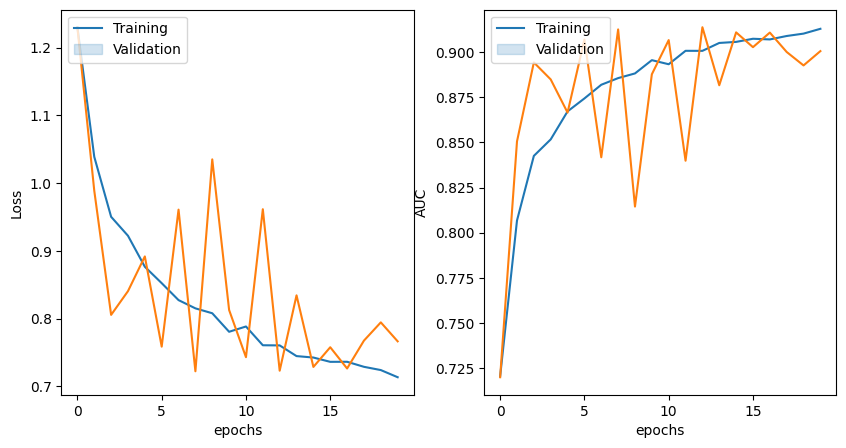

In [ ]:
# Generates predictions for the test data
test_predictions = cell_baseline_model.predict_generator(cell_test_generator)

# Converts the probabilities to integers 
test_predictions_int = np.argmax(test_predictions, axis=1)

# Stores actual test data labels
test_labels = cell_test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_int)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
recall = recall_score(test_labels, test_predictions_int, average='macro')
accuracy = (test_predictions_int == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(cell_baseline_model)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=cell_baseline_history.history, x=cell_baseline_history.epoch, y='loss', ax=axes[0])
sns.lineplot(data=cell_baseline_history.history, x=cell_baseline_history.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=cell_baseline_history.history, x=cell_baseline_history.epoch, y='auc', ax=axes[1])
sns.lineplot(data=cell_baseline_history.history, x=cell_baseline_history.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

### Observations
* We can see that the model is very weak, and is overfitting to the data, with large spikes in validation data performance. 
* In addition, the confusion matrix suggests that class 3 is being struggled to be predicted, which can be explained by the following cell where there is a very big class imbalance. 

We will attempt to remedy this using class_weights.


In [ ]:
cell_train.value_counts('cellType')

cellType
2    2615
1    1713
0     939
3     663
dtype: int64

We will now fit class_weights to the model to attempt to reduce the overfitting and fix the class imbalance.

In [ ]:
num_class_0 = cell_train[cell_train['cellType'] == '0'].shape[0]
num_class_1 = cell_train[cell_train['cellType'] == '1'].shape[0]
num_class_2 = cell_train[cell_train['cellType'] == '2'].shape[0]
num_class_3 = cell_train[cell_train['cellType'] == '3'].shape[0]

# Calculates the class weights
total_samples = cell_train.shape[0]
class_weight = {
    0: total_samples / (4 * num_class_0),
    1: total_samples / (4 * num_class_1),
    2: total_samples / (4 * num_class_2),
    3: total_samples / (4 * num_class_3)
}

In [ ]:
cell_baseline_model_weighted = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_1),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_2, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])
cell_baseline_model_weighted.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy','categorical_accuracy'])
cell_baseline_history_weighted = cell_baseline_model_weighted.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=20, verbose=0, class_weight=class_weight)

<ipython-input-55-fe524f538374>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cell_baseline_history_weighted = cell_baseline_model_weighted.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=20, verbose=0, class_weight=class_weight)
/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


<ipython-input-52-c26dcaef3125>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = cell_baseline_model_weighted.predict_generator(cell_test_generator)


Confusion Matrix:
[[577  23  10  31]
 [ 97 290  73 124]
 [ 50   4 237   4]
 [371  29   3  77]]
AUC Score: 0.83709214256255
Recall: 0.5901344614702861
Accuracy: 0.5905
63/63 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.44      0.97      0.60       641
           1       0.94      0.14      0.25       584
           2       0.75      0.52      0.61       295
           3       0.14      0.08      0.10       480

    accuracy                           0.45      2000
   macro avg       0.57      0.43      0.39      2000
weighted avg       0.56      0.45      0.38      2000



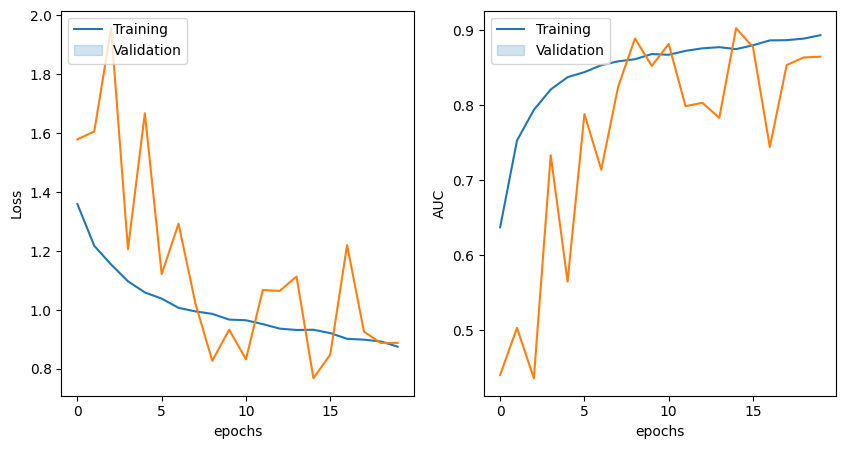

In [ ]:
# Generates predictions for the test data
test_predictions = cell_baseline_model_weighted.predict_generator(cell_test_generator)

# Converts the probabilities to integers 
test_predictions_int = np.argmax(test_predictions, axis=1)

# Stores actual test data labels
test_labels = cell_test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_int)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
recall = recall_score(test_labels, test_predictions_int, average='macro')
accuracy = (test_predictions_int == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(cell_baseline_model)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=cell_baseline_history_weighted.history, x=cell_baseline_history_weighted.epoch, y='loss', ax=axes[0])
sns.lineplot(data=cell_baseline_history_weighted.history, x=cell_baseline_history_weighted.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=cell_baseline_history_weighted.history, x=cell_baseline_history_weighted.epoch, y='auc', ax=axes[1])
sns.lineplot(data=cell_baseline_history_weighted.history, x=cell_baseline_history_weighted.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

It appears as though using class_weights reduces the performance significantly. The model is now overfitting to the data.

We will now perform regularization to improve the generalisation of our model.

In [58]:
reg_lambda = 0.01

cell_baseline_model_weighted = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_1, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

cell_baseline_model_weighted.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy','categorical_accuracy'])
cell_baseline_history_weighted = cell_baseline_model_weighted.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=20, verbose=0)

<ipython-input-58-6de4e0290fec>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cell_baseline_history_weighted = cell_baseline_model_weighted.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=20, verbose=0)


<ipython-input-59-c26dcaef3125>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = cell_baseline_model_weighted.predict_generator(cell_test_generator)


Confusion Matrix:
[[546  66  29   0]
 [ 79 410  95   0]
 [ 18   6 271   0]
 [375 101   4   0]]
AUC Score: 0.8217861359003379
Recall: 0.6181232335200071
Accuracy: 0.6135
63/63 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       641
           1       0.66      0.71      0.68       584
           2       0.64      0.97      0.77       295
           3       0.40      0.11      0.17       480

    accuracy                           0.60      2000
   macro avg       0.57      0.62      0.56      2000
weighted avg       0.57      0.60      0.56      2000



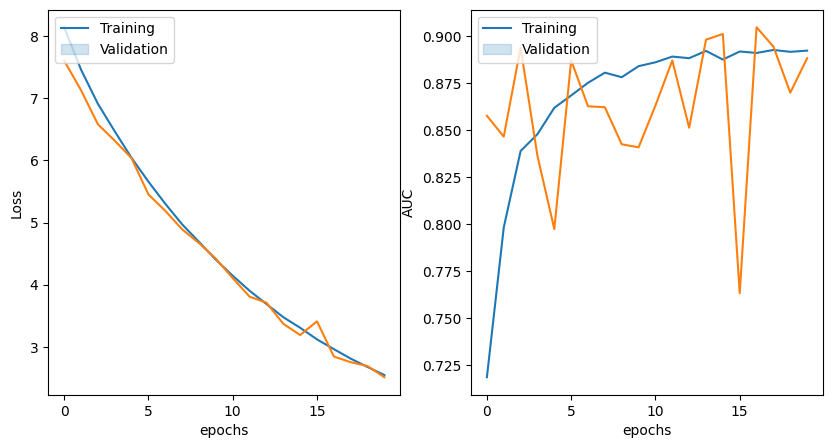

In [59]:
# Generates predictions for the test data
test_predictions = cell_baseline_model_weighted.predict_generator(cell_test_generator)

# Converts the probabilities to integers 
test_predictions_int = np.argmax(test_predictions, axis=1)

# Stores actual test data labels
test_labels = cell_test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_int)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
recall = recall_score(test_labels, test_predictions_int, average='macro')
accuracy = (test_predictions_int == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(cell_baseline_model)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=cell_baseline_history_weighted.history, x=cell_baseline_history_weighted.epoch, y='loss', ax=axes[0])
sns.lineplot(data=cell_baseline_history_weighted.history, x=cell_baseline_history_weighted.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=cell_baseline_history_weighted.history, x=cell_baseline_history_weighted.epoch, y='auc', ax=axes[1])
sns.lineplot(data=cell_baseline_history_weighted.history, x=cell_baseline_history_weighted.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

The overfitting has been significantly improved by regularization we can see.

We will now attempt to add dropout, as similar to how we did as before, to improve the overfitting and generalization capabilities.

In [61]:
dropout_rate = 0.1
reg_lambda = 0.01

cell_baseline_model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_1, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

cell_baseline_model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['AUC','Recall','accuracy','categorical_accuracy'])
cell_baseline_history_drop = cell_baseline_model_drop.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=20, verbose=0)

<ipython-input-61-a701c26f90a7>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cell_baseline_history_drop = cell_baseline_model_drop.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=20, verbose=0)


<ipython-input-62-e9509e7ab189>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = cell_baseline_model_drop.predict_generator(cell_test_generator)


Confusion Matrix:
[[483 109  48   1]
 [ 46 434 103   1]
 [  2   7 286   0]
 [338 134   7   1]]
AUC Score: 0.8314194809797156
Recall: 0.6170589210235462
Accuracy: 0.602
63/63 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.56      0.75      0.64       641
           1       0.63      0.74      0.68       584
           2       0.64      0.97      0.77       295
           3       0.33      0.00      0.00       480

    accuracy                           0.60      2000
   macro avg       0.54      0.62      0.53      2000
weighted avg       0.54      0.60      0.52      2000



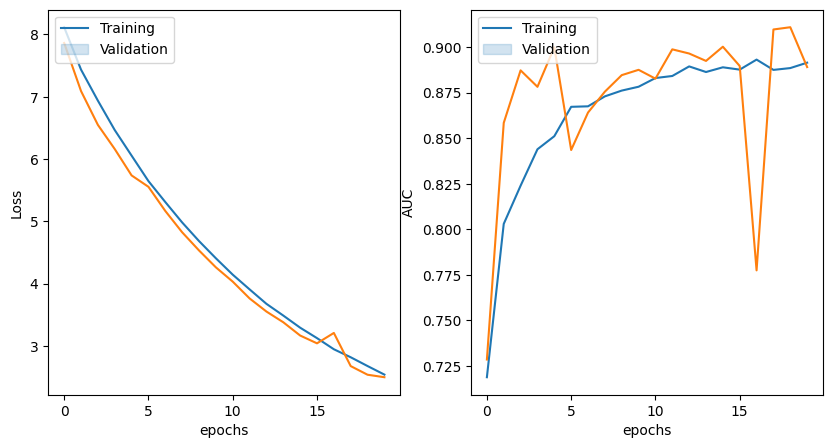

In [62]:
# Generates predictions for the test data
test_predictions = cell_baseline_model_drop.predict_generator(cell_test_generator)

# Converts the probabilities to integers 
test_predictions_int = np.argmax(test_predictions, axis=1)

# Stores actual test data labels
test_labels = cell_test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_int)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
recall = recall_score(test_labels, test_predictions_int, average='macro')
accuracy = (test_predictions_int == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(cell_baseline_model_drop)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=cell_baseline_history_drop.history, x=cell_baseline_history_drop.epoch, y='loss', ax=axes[0])
sns.lineplot(data=cell_baseline_history_drop.history, x=cell_baseline_history_drop.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=cell_baseline_history_drop.history, x=cell_baseline_history_drop.epoch, y='auc', ax=axes[1])
sns.lineplot(data=cell_baseline_history_drop.history, x=cell_baseline_history_drop.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [67]:
dropout_rate = 0.1
reg_lambda = 0.01
FILTERS = 32  # Number of filters in the convolutional layers
KERNEL_SIZE = (3, 3)  # Kernel size for convolutional layers
POOL_SIZE = (2, 2)  # Pooling size for max pooling layers

# Create the model
cell_cnn_model = tf.keras.Sequential([
    Conv2D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu', input_shape=INPUT_DIM),
    MaxPooling2D(pool_size=POOL_SIZE),
    Conv2D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    MaxPooling2D(pool_size=POOL_SIZE),
    Flatten(),
    Dense(units=HIDDEN_LAYER_DIM_1, activation='relu', kernel_regularizer=l2(reg_lambda)),
    Dropout(rate=dropout_rate),
    Dense(units=HIDDEN_LAYER_DIM_2, activation='relu', kernel_regularizer=l2(reg_lambda)),
    Dropout(rate=dropout_rate),
    Dense(units=OUTPUT_CLASSES, activation='softmax')
])

# Compile the model
cell_cnn_model.compile(optimizer='SGD',
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['AUC', 'Recall', 'accuracy', 'categorical_accuracy'])

# Train the model
cell_cnn_history = cell_cnn_model.fit_generator(cell_train_generator,
                                                validation_data=cell_validation_generator,
                                                epochs=20,
                                                verbose=0)

<ipython-input-67-f1398a4a7bc0>:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cell_cnn_history = cell_cnn_model.fit_generator(cell_train_generator,


<ipython-input-69-3f872d6c33ba>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = cell_cnn_model.predict_generator(cell_test_generator)


Confusion Matrix:
[[495 134  12   0]
 [ 31 523  30   0]
 [ 52   6 237   0]
 [280 194   6   0]]
AUC Score: 0.8651674116014807
Recall: 0.6177921662373809
Accuracy: 0.6275
63/63 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.58      0.77      0.66       641
           1       0.61      0.90      0.73       584
           2       0.83      0.80      0.82       295
           3       0.00      0.00      0.00       480

    accuracy                           0.63      2000
   macro avg       0.50      0.62      0.55      2000
weighted avg       0.49      0.63      0.54      2000



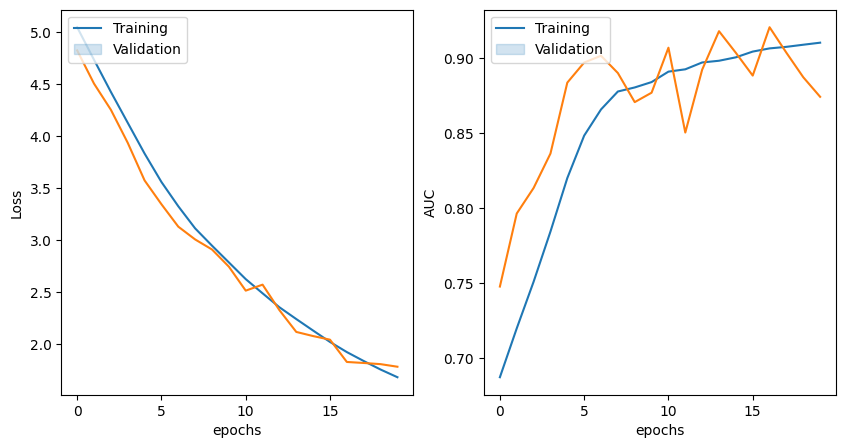

In [69]:
# Generates predictions for the test data
test_predictions = cell_cnn_model.predict_generator(cell_test_generator)

# Converts the probabilities to integers 
test_predictions_int = np.argmax(test_predictions, axis=1)

# Stores actual test data labels
test_labels = cell_test_generator.labels
# Creates confusion matrix
cm = confusion_matrix(test_labels, test_predictions_int)

# Calculates the different metrics for the predictions
auc_score = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
recall = recall_score(test_labels, test_predictions_int, average='macro')
accuracy = (test_predictions_int == test_labels).mean()

print("Confusion Matrix:")
print(cm)
print("AUC Score:", auc_score)
print("Recall:", recall)
print("Accuracy:", accuracy)
classification_rep(cell_cnn_model)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=cell_cnn_history.history, x=cell_cnn_history.epoch, y='loss', ax=axes[0])
sns.lineplot(data=cell_cnn_history.history, x=cell_cnn_history.epoch, y='val_loss', ax=axes[0])
sns.lineplot(data=cell_cnn_history.history, x=cell_cnn_history.epoch, y='auc', ax=axes[1])
sns.lineplot(data=cell_cnn_history.history, x=cell_cnn_history.epoch, y='val_auc', ax=axes[1])

axes[0].set(xlabel='epochs', ylabel='Loss')
axes[1].set(xlabel='epochs', ylabel='AUC')

axes[0].legend(['Training', 'Validation'], loc='upper left')
axes[1].legend(['Training', 'Validation'], loc='upper left')

plt.show()